# IBM Analog Hardware Acceleration Kit (AIHWKIT): Hardware-aware Training for Accurate Inference on Analog Hardware

### Authors: [Julian Büchel](https://www.linkedin.com/in/julian-büchel-0673991a3/), [Manuel Le Gallo-Bourdeau](https://research.ibm.com/people/manuel-le-gallo-bourdeau), and [Kaoutar El Maghraoui](https://www.linkedin.com/in/kaoutar-el-maghraoui/)



<a href="https://colab.research.google.com/github/IBM/aihwkit/blob/master/notebooks/tutorial/hw_aware_training.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg"/>
</a>

The IBM Analog Hardware Acceleration Kit (AIHWKIT) is an open-source Python toolkit for exploring and using the capabilities of in-memory computing devices (PCM, RRAM and others) in the context of artificial intelligence. The PyTorch integration consists of a series of primitives and features that allow using the toolkit within PyTorch.
The GitHub repository can be found at: https://github.com/IBM/aihwkit
To learn more about Analog AI and the harware befind it, refer to this webpage: https://aihw-composer.draco.res.ibm.com/about

### Installing AIHWKIT

The first thing to do is install AIHWKIT and dependencies in your environment. The preferred way to install this package is by using the Python package index (please uncomment this line to install in your environment if not previously installed):

In [1]:
# To install the cpu-only enabled kit, un-comment the line below
# %pip install aihwkit

# To install the GPU-enabled wheel go to https://aihwkit.readthedocs.io/en/latest/advanced_install.html#install-the-aihwkit-using-pip
# and copy the option on GPU options that best suits your enviroment and paste it below and run the cell. For example, Python 3.10 and CUDA 12.1:
# !wget https://aihwkit-gpu-demo.s3.us-east.cloud-object-storage.appdomain.cloud/aihwkit-0.9.2+cuda121-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
# %pip install aihwkit-0.9.2+cuda121-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl


Upload the utils directory in your runtime environment if you are using Google Colab.

In [1]:
# various utility functions

import torch
import torch.nn.functional as F
import torch.nn.init as init
import torchvision
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def _weights_init(m):
    if isinstance(m, torch.nn.Linear) or isinstance(m, torch.nn.Conv2d):
        init.kaiming_normal_(m.weight)


class LambdaLayer(torch.nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(torch.nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option="A"):
        super(BasicBlock, self).__init__()
        self.conv1 = torch.nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = torch.nn.BatchNorm2d(planes)
        self.conv2 = torch.nn.Conv2d(
            planes, planes, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = torch.nn.BatchNorm2d(planes)

        self.shortcut = torch.nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == "A":
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(
                    lambda x: F.pad(
                        x[:, :, ::2, ::2],
                        (0, 0, 0, 0, planes // 4, planes // 4),
                        "constant",
                        0,
                    )
                )
            elif option == "B":
                self.shortcut = torch.nn.Sequential(
                    torch.nn.Conv2d(
                        in_planes,
                        self.expansion * planes,
                        kernel_size=1,
                        stride=stride,
                        bias=False,
                    ),
                    torch.nn.BatchNorm2d(self.expansion * planes),
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(torch.nn.Module):
    def __init__(self, block, num_blocks, n_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = torch.nn.Conv2d(
            3, 16, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = torch.nn.Linear(64, n_classes)

        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return torch.nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def resnet32(n_classes=10):
    return ResNet(BasicBlock, [5, 5, 5], n_classes=n_classes)


class TorchCutout(object):
    def __init__(self, length, fill=(0.0, 0.0, 0.0)):
        self.length = length
        self.fill = torch.tensor(fill).reshape(shape=(3, 1, 1))

    def __call__(self, img):
        h = img.size(1)
        w = img.size(2)
        y = np.random.randint(h)
        x = np.random.randint(w)
        y1 = np.clip(y - self.length // 2, 0, h)
        y2 = np.clip(y + self.length // 2, 0, h)
        x1 = np.clip(x - self.length // 2, 0, w)
        x2 = np.clip(x + self.length // 2, 0, w)
        img[:, y1:y2, x1:x2] = self.fill
        return img


# Load dataset
def load_cifar10(batch_size, path):
    transform_train = torchvision.transforms.Compose(
        [
            torchvision.transforms.RandomCrop(32, padding=4),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
            ),
            TorchCutout(length=8),
        ]
    )

    transform_test = torchvision.transforms.Compose(
        [
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
            ),
        ]
    )

    trainset = torchvision.datasets.CIFAR10(
        root=path, train=True, download=True, transform=transform_train
    )
    testset = torchvision.datasets.CIFAR10(
        root=path, train=False, download=True, transform=transform_test
    )
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=1
    )
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=1
    )

    return trainloader, testloader


In [4]:
torch.load("./resnet_baseline_drift.th")

/tmp/ipykernel_2114837/3261810915.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load("./resnet_baseline_drift.th")


tensor([[91.4420],
        [91.2600],
        [10.4760],
        [10.4500],
        [10.0720]])

In [11]:
import numpy
numpy.load("AccuracyVSTime_ResNET_HWA.npy", allow_pickle=True)

array([[91.84000396728516, 91.80599975585938, 10.374000549316406,
        10.243999481201172, 10.333999633789062],
       [92.406005859375, 92.37799835205078, 69.79000091552734,
        40.507999420166016, 14.311999320983887],
       [92.2719955444336, 92.40800476074219, 92.28799438476562,
        92.30799865722656, 92.197998046875]], dtype=object)

In [25]:


# - Generic imports
import torch
import numpy as np
from tqdm import tqdm

# - AIHWKIT related imports
from aihwkit.nn.conversion import convert_to_analog
from aihwkit.optim import AnalogSGD
from aihwkit.simulator.presets.utils import IOParameters

from aihwkit.simulator.parameters.io import IOParametersIRDropT
from aihwkit.inference.noise.pcm import PCMLikeNoiseModel
from aihwkit.inference import ReRamCMONoiseModel
from aihwkit.inference.compensation.drift import GlobalDriftCompensation
from aihwkit.simulator.configs import InferenceRPUConfig
from aihwkit.simulator.configs.utils import (
    WeightModifierType,
    BoundManagementType,
    WeightClipType,
    NoiseManagementType,
    WeightRemapType,
)

## RPU Config
The RPU configuration specifies the parameters necessary for hardware-aware training. The `InferenceRPUConfig` comes with default settings, which are typically changed after initialization. Note that this determines the tile backend used. `InferenceRPUConfig` uses the CUDA implementation of the tile, while `TorchInferenceRPUConfig` uses a pure torch based approach. Using the CUDA tile is typically faster if convolutions are used because it supports an indexed implementation, while the torch-based implementation treats a convolution as a linear operation by unfolding the input, which is typically slow.

### `rpu_config.modifier`
The modifier injects noise into the weights for each batch during training. The type of the noise can be set by `rpu_config.modifier.type`. In this case, we use additive Gaussian noise, which works well. The additive Gaussian noise is applied to the weights on the tile, which are normalized to [-1,1] in our case (more about that in `rpu_config.mapping`). Since the weights are normalized, the magnitude `rpu_config.modifier.std_dev` corresponds to the percent of noise relative to the weights. In this case, we apply 6% noise.

### `rpu_config.mapping`
We can also put the bias in analog by setting `rpu_config.mapping.digital_bias`, which we don't do since the bias is implemented in digital on most hardware. The following parameters relate to how the weights are normalized to the default range [-1,1]. `rpu_config.mapping.weight_scaling_omega=1.0` initially sets the weight scale to the `abs().max()` of the weight. `WeightRemapType.LAYERWISE_SYMMETRIC` ensures that each weight gets remapped to [-1,1] after every weight update.

### `rpu_config.clip`
Tight weight distributions are important when we map the weights to conductance values. This can be ensured by specifying `rpu_config.clip.type`. In this case, we clip each weight after every batch update around `rpu_config.clip.sigma` many standard deviations of the weights. I.e. `w = w.clamp(-a*w.std(),a*w.std())`.

### `rpu_config.forward`
This part of the RPU config determines the non-idealities at a tile level, e.g., output noise, short-term weight noise, quantization, etc. In this case, we set the DAC and ADC resolution to 8 bits and the input bound to 1.0. This has the effect that the inputs are mapped to [-1,1] and quantized to 8 bits. The output bound is set to 12.0. Note that all of the non-idealities of the forward pass can be turned off by setting `rpu_config.forward.is_perfect=True`. This also has the effect of faster runtime since we can take a shortcut in the MVM computation. The bound management typically manages the input scale when there appears clipping at the ADC. We can, for example, configure it so that the input is reduced until no clipping at the ADCs occurs. We set it to None in this case. The noise management determines how the inputs are mapped to the input bound (here set to 1.0). If the noise management is set to `ABS_MAX`, we dynamically compute the `abs().max()` of the input and use this to normalize the input. If the input ranges are learned, set this to `NONE`.

### `rpu_config.pre_post.input_range`
Analog and digital accelerators typically quantize their MVM inputs by multiplying them by a scalar that maps the values to a specific range (e.g., for int8 this scale would be 127. / `input_range of input`). We can learn the input range parameter by setting `rpu_config.pre_post.input_range.enable=True`. We can calibrate the initial input range from data by setting `rpu_config.pre_post.input_range.init_from_data` to the number of batches we would like to use for this calibration. In this case, 3.0 standard deviations are taken from the batch to update the input range learning. After 50 seen batches, the input ranges are updated from gradients. Generally, the input ranges are widened after initialization. When less than `1-rpu_config.pre_post.input_range.input_min_percentage` percent of the inputs are clipped when the current input range is used, the input range is shrunk with a rate proportional to `rpu_config.pre_post.input_range.decay`. In other words, when the input range is too loose (i.e., no inputs are clipped), we shrink it again. Increasing the decay increases the speed with which we shrink it.

Finally, we set the `noise_model` used for inference. This `noise_model` determines, for example, what type of programming noise is applied when we program the device. We can also simulate drift and even drift compensation. The compensation method can be set by `rpu_config.drift_compensation`. Here we use global drift compensation, which uses a reference input to determine the optimal scale that needs to be applied to the outputs in order to compensate for the drifted weights.


In [14]:
input_prec = 36
output_prec = 8
wire = 0.35
def gen_rpu_config():
    rpu_config = InferenceRPUConfig()
    rpu_config.modifier.std_dev = 0.06
    rpu_config.modifier.type = WeightModifierType.ADD_NORMAL

    rpu_config.mapping.digital_bias = True
    rpu_config.mapping.weight_scaling_omega = 1.0
    rpu_config.mapping.weight_scaling_columnwise = False
    rpu_config.mapping.out_scaling_columnwise = False
    rpu_config.remap.type = WeightRemapType.LAYERWISE_SYMMETRIC
    rpu_config.mapping.max_input_size = 256
    rpu_config.mapping.max_output_size = 256
    rpu_config.clip.type = WeightClipType.LAYER_GAUSSIAN
    rpu_config.clip.sigma = 2.0

    rpu_config.forward = IOParametersIRDropT()
    rpu_config.forward.is_perfect = False
    rpu_config.forward.out_noise = 0.04
    rpu_config.forward.inp_bound = 1.0
    rpu_config.forward.inp_res = 1 / (2**input_prec - 2)
    rpu_config.forward.out_bound = 10
    rpu_config.forward.out_res = 1 / (2**input_prec - 2)
    rpu_config.forward.bound_management = BoundManagementType.NONE
    rpu_config.forward.noise_management = NoiseManagementType.ABS_MAX
    rpu_config.forward.ir_drop_g_ratio = 1.0 / wire / 88e-6
    rpu_config.forward.ir_drop = 1.0
    rpu_config.forward.ir_drop_rs = wire

    rpu_config.pre_post.input_range.enable = True
    rpu_config.pre_post.input_range.decay = 0.01
    rpu_config.pre_post.input_range.init_from_data = 50
    rpu_config.pre_post.input_range.init_std_alpha = 3.0
    rpu_config.pre_post.input_range.input_min_percentage = 0.995
    rpu_config.pre_post.input_range.manage_output_clipping = False

    rpu_config.noise_model = PCMLikeNoiseModel(g_max=25.0)
    rpu_config.drift_compensation = None
    #rpu_config.noise_model = ReRamCMONoiseModel(g_max=88.19, g_min=9.0, acceptance_range=2.0)
    #rpu_config.drift_compensation = None
    return rpu_config

In [26]:
input_prec = 6
output_prec = 8
wire = 0.35
PCM = False
def gen_rpu_config(noise_model):
    my_rpu_config = InferenceRPUConfig()
    my_rpu_config.modifier.std_dev = 0.06
    my_rpu_config.modifier.type = WeightModifierType.ADD_NORMAL
    my_rpu_config.mapping.max_input_size = 256
    my_rpu_config.mapping.max_output_size = 256
    my_rpu_config.mapping.digital_bias = True
    my_rpu_config.mapping.weight_scaling_omega = 1.0
    my_rpu_config.mapping.weight_scaling_columnwise = False
    my_rpu_config.mapping.out_scaling_columnwise = False
    my_rpu_config.remap.type = WeightRemapType.LAYERWISE_SYMMETRIC
    my_rpu_config.clip.type = WeightClipType.LAYER_GAUSSIAN
    my_rpu_config.clip.sigma = 2.0
    my_rpu_config.forward = IOParametersIRDropT()
    my_rpu_config.forward.is_perfect = False
    if PCM:
        my_rpu_config.noise_model = PCMLikeNoiseModel(g_max=25.0)
        my_rpu_config.drift_compensation = None
        my_rpu_config.forward.ir_drop_g_ratio = 1.0 / 0.35 / 25e-6 # change to 25w-6 when using PCM
    else:
        my_rpu_config.noise_model = noise_model 
        my_rpu_config.drift_compensation = None # by default is GlobalCompensation from PCM
        my_rpu_config.forward.ir_drop_g_ratio = 1.0 / 0.35 / 88e-6 # change to 25w-6 when using PCM

    #my_rpu_config.drift_compensation = None
    
    my_rpu_config.modifier.std_dev = 0.06
    my_rpu_config.modifier.type = WeightModifierType.ADD_NORMAL

    
    my_rpu_config.forward.inp_res = 1 / (2**input_prec - 2)
    my_rpu_config.forward.out_res = 1 / (2**output_prec - 2)
    #my_rpu_config.forward.out_res = -1
    #my_rpu_config.forward.inp_res = -1
    my_rpu_config.forward.out_noise = 0.06 # Output on the current addition (?)
    my_rpu_config.forward.ir_drop = 1.0 # TODO set to 1.0 when activating IR drop effects
    my_rpu_config.forward.ir_drop_rs = 0.35 # Default: 0.15
    #my_rpu_config.forward.noise_management = NoiseManagementType.ABS_MAX # Rescale back the output with the scaling for normalizing the input
    #my_rpu_config.forward.bound_management = BoundManagementType.NONE # No learning of the ranges
    
    #my_rpu_config.forward.out_bound = 20.0  # quite restrictive
    my_rpu_config.pre_post.input_range.enable = True
    my_rpu_config.pre_post.input_range.decay = 0.01
    my_rpu_config.pre_post.input_range.init_from_data = 50
    my_rpu_config.pre_post.input_range.init_std_alpha = 3.0
    my_rpu_config.pre_post.input_range.input_min_percentage = 0.995
    my_rpu_config.pre_post.input_range.manage_output_clipping = False
    return my_rpu_config

In [27]:
# - Standard train and test routines
def train_step(model, optimizer, criterion, trainloader):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for inputs, targets in trainloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    return train_loss / total, 100.0 * correct / total


def test_step(model, criterion, testloader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    print(f"Test loss {test_loss/total:.4f} test acc. {100.*correct/total:.2f}%")
    return 100.0 * correct / total

In [28]:
# - Set seeds
torch.manual_seed(0)
np.random.seed(0)
import os
# - Get the dataloader
batch_size = 128
trainloader, testloader = load_cifar10(
    batch_size=batch_size, path=os.path.expanduser("~/Data/")
)

# - Change to True if one of the models should be re-trained
retrain_baseline = False
retrain_finetuned_model = True

# - Some hyperparameters
lr = 0.05
epochs = 200
epochs_finetuning = 100

Files already downloaded and verified
Files already downloaded and verified


In [29]:
# - Define model, criterion, optimizer and scheduler.
model = resnet32()
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

We typically first pre-train a baseline model that we later fine-tune using noise injection.

In [30]:
# - Pre-training of the network
import os
if not os.path.exists("Models"):
    os.makedirs("Models")
if retrain_baseline:
    pbar = tqdm(range(epochs))
    for epoch in pbar:
        train_loss, train_acc = train_step(model, optimizer, criterion, trainloader)
        pbar.set_description(f"Epoch {epoch} Train loss: {train_loss:.4f} train acc. {train_acc:.2f}%")
        if epoch % 5 == 0:
            test_step(model, criterion, testloader)
        scheduler.step()
    torch.save(model.state_dict(), "Models/pre_trained_model.th")
else:
    import requests
    url = 'https://aihwkit-tutorial.s3.us-east.cloud-object-storage.appdomain.cloud/pre_trained_model.th'
    response = requests.get(url)
    with open('Models/pre_trained_resnet.th', 'wb') as f:
        f.write(response.content)
    model.load_state_dict(torch.load("Models/pre_trained_resnet.th", map_location=device))
    print(f"Pretrained test acc. {test_step(model, criterion, testloader)}%")

/tmp/ipykernel_2111725/3910390277.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("Models/pre_trained_resnet.th", map_location=device))

Test loss 0.0016 test acc. 94.12%
Pretrained test acc. 94.12%


In [ ]:
#"mean": [-0.08900206],
import matplotlib.pyplot as plt
noise_model = ReRamCMONoiseModel(g_max=88.19,
                                     g_min=9.0,
                                     acceptance_range=0.2,
                                     decay_dict={"mean": [-0.08900206],
                                                 "std": [0.04201137, 0.41183342]})
rpu_config = gen_rpu_config(noise_model=noise_model)
#rpu_config = gen_rpu_config()
converted_model = convert_to_analog(model, rpu_config)
#t_inferences = [0, 1, 3600, 3600 * 24, 3600 * 24 * 365 * 10]
t_inferences = [10, 10e3, 10e4, 10e5]
#t_inferences = [0, 3600 * 24 * 365 * 10]
#labels = ["0s", "1s", "1h", "1d", "10y"]
print("Programming: ",test_step(converted_model, criterion, testloader))
labels = ["0s",  "10y"]
color = [ 'lightskyblue', 'lightcoral']
n_rep = 1
drifted_test_accs = torch.zeros(size=(len(t_inferences), 1))
plt.figure()
for i,t in enumerate(t_inferences):
    for j in range(n_rep):
        converted_model.drift_analog_weights(t)
        print("Drifted at t: ", t)
        accuracy = test_step(converted_model, criterion, testloader)
        drifted_test_accs[i] += accuracy
        print(f"Accuracy of the analog model: {accuracy:.2f}%")
        w, _ = (
        converted_model
        .layer3[0]
        .conv1.analog_module.get_weights(apply_weight_scaling=True)
        )
        real_weights = model.layer3[0].conv1.weight
        real_weights = real_weights.flatten(start_dim=1, end_dim=-1)
        print(real_weights.shape)
        print(w.shape)
        print("Weight error:", torch.mean(torch.abs(real_weights.cpu() - w.cpu())).item())
"""
    
    plt.hist(w.flatten().detach().numpy(), color=color[i], bins=300, alpha =0.5, label=f"Time of inference = {labels[i]}")
    mean_w = w.flatten().detach().numpy()
    std_w = mean_w.std()
    mean_w = mean_w.mean()
    #plt.axvline(mean_w - std_w, color='b', linestyle='dotted', linewidth=2, label =f"STD:{std_w:.4f}")
    #plt.axvline(mean_w + std_w, color='b', linestyle='dotted', linewidth=2)
    #plt.axvspan(mean_w - std_w, mean_w + std_w, color='blue', alpha=0.2)
    #plt.axvline(mean_w)
    drifted_test_accs[i]/= n_rep
plt.legend()
plt.xlabel("Unnormalized weight")
plt.ylabel("Count")
#plt.title(f"Time of inference = {labels[i]}")
plt.show()
"""

In [12]:
torch.save(drifted_test_accs, "resnet_baseline_drift.th")

In [38]:
noise_model = ReRamCMONoiseModel(g_max=88.19,
                                     g_min=9.0,
                                     acceptance_range=0.2,
                                    decay_dict={"mean": [0],
                                                 "std": [0.04201137, 0.41183342]})
rpu_config = gen_rpu_config(noise_model=noise_model)
# analog_model = convert_to_analog(model, rpu_config)
analog_model.load_state_dict(
        torch.load("Models/hwa_reram_resnet_6_8bits_input_range_Claudia.th", map_location=device)
    )
analog_model.eval()
analog_model.program_analog_weights(noise_model=noise_model)
t_inferences = [0, 1, 3600, 3600 * 24, 3600 * 24 * 365 * 10]
n_rep = 5
drifted_test_accs = torch.zeros(size=(len(t_inferences),n_rep))
for i,t in enumerate(t_inferences):
    for j in range(n_rep):
        analog_model.drift_analog_weights(t)
        print("Drifted at t: ", t)
        accuracy = test_step(analog_model, criterion, testloader)
        drifted_test_accs[i, j] = accuracy
        print(f"Accuracy of the analog model: {accuracy:.2f}%")

drifted_test_accs = drifted_test_accs.mean(dim=1)

filename = "AccuracyVSTime_ResNET_HWA.npy"

# Controlla se il file esiste già e carica i dati precedenti
if os.path.exists(filename):
    acc_file = np.load(filename, allow_pickle=True).tolist()  # Carica i dati esistenti
else:
    acc_file = []  # Se il file non esiste, inizializza una lista vuota

# Aggiunge i nuovi dati alla lista
acc_file.append(drifted_test_accs)
print('file', acc_file)
print('error now', drifted_test_accs)
# Salva il file aggiornato
np.save(filename, np.array(acc_file, dtype=object))


/tmp/ipykernel_2111725/1739357087.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load("Models/hwa_reram_resnet_6_8bits_input_range_Claudia.th", map_location=devic

Drifted at t:  0
Test loss 0.0020 test acc. 92.19%
Accuracy of the analog model: 92.19%
Drifted at t:  0
Test loss 0.0020 test acc. 92.16%
Accuracy of the analog model: 92.16%
Drifted at t:  0
Test loss 0.0020 test acc. 92.34%
Accuracy of the analog model: 92.34%
Drifted at t:  0
Test loss 0.0020 test acc. 92.33%
Accuracy of the analog model: 92.33%
Drifted at t:  0
Test loss 0.0020 test acc. 92.34%
Accuracy of the analog model: 92.34%
Drifted at t:  1
Test loss 0.0020 test acc. 92.34%
Accuracy of the analog model: 92.34%
Drifted at t:  1
Test loss 0.0020 test acc. 92.30%
Accuracy of the analog model: 92.30%
Drifted at t:  1
Test loss 0.0020 test acc. 92.39%
Accuracy of the analog model: 92.39%
Drifted at t:  1
Test loss 0.0020 test acc. 92.59%
Accuracy of the analog model: 92.59%
Drifted at t:  1
Test loss 0.0020 test acc. 92.42%
Accuracy of the analog model: 92.42%
Drifted at t:  3600
Test loss 0.0020 test acc. 92.40%
Accuracy of the analog model: 92.40%
Drifted at t:  3600
Test loss

We first convert our model to an analog model using `convert_to_analog` where we pass the model and the RPU config. The optimizer, in this case, `AnalogSGD`.
The rest is standard training. Analog models can be easily saved like regular models.

In [33]:
# - Fine-tuning
noise_model = ReRamCMONoiseModel(g_max=88.19,
                                     g_min=9.0,
                                     acceptance_range=0.2)
analog_model = convert_to_analog(model, gen_rpu_config(noise_model=noise_model))
if retrain_finetuned_model:
    optimizer = AnalogSGD(
        analog_model.parameters(), lr=lr / 10.0, momentum=0.9, weight_decay=5e-4
    )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    test_accs = torch.empty(epochs_finetuning)
    pbar = tqdm(range(epochs_finetuning))
    for epoch in pbar:
        train_loss, train_acc = train_step(analog_model, optimizer, criterion, trainloader)
        pbar.set_description(f"Epoch {epoch} Train loss: {train_loss:.4f} train acc. {train_acc:.2f}%")
        test_accs[epoch] = test_step(analog_model, criterion, testloader)
        scheduler.step()

    torch.save(analog_model.state_dict(), "Models/hwa_reram_resnet_6_8bits_input_range_Claudia.th")
    #torch.save(test_accs, "Models/test_accs.th")

else:
    import requests
    url_test_accs = 'https://aihwkit-tutorial.s3.us-east.cloud-object-storage.appdomain.cloud/test_accs.th'
    url_finetuned_model = 'https://aihwkit-tutorial.s3.us-east.cloud-object-storage.appdomain.cloud/finetuned_model_0.9.1.th'
    
    response_test_accs = requests.get(url_test_accs)
    with open('Models/test_accs.th', 'wb') as f:
        f.write(response_test_accs.content)
    
    response_finetuned_model = requests.get(url_finetuned_model)

    with open('Models/finetuned_model_0.9.1.th', 'wb') as f:
        f.write(response_finetuned_model.content)

    test_accs = torch.load("Models/test_accs.th")
    analog_model.load_state_dict(
        torch.load("Models/finetuned_model_0.9.1.th", map_location=device)
    )
    print(f"Finetuned test acc. {test_step(analog_model, criterion, testloader)}%")

Epoch 0 Train loss: 0.0083 train acc. 63.19%:   1%|▎                                  | 1/100 [01:26<2:22:48, 86.55s/it]

Test loss 0.0056 test acc. 74.71%


Epoch 1 Train loss: 0.0053 train acc. 76.25%:   2%|▋                                  | 2/100 [02:51<2:19:46, 85.58s/it]

Test loss 0.0049 test acc. 79.32%


Epoch 2 Train loss: 0.0041 train acc. 81.53%:   3%|█                                  | 3/100 [04:16<2:17:36, 85.12s/it]

Test loss 0.0043 test acc. 82.40%


Epoch 3 Train loss: 0.0034 train acc. 84.86%:   4%|█▍                                 | 4/100 [05:39<2:15:09, 84.48s/it]

Test loss 0.0034 test acc. 85.64%


Epoch 4 Train loss: 0.0029 train acc. 87.19%:   5%|█▊                                 | 5/100 [07:02<2:12:49, 83.89s/it]

Test loss 0.0032 test acc. 86.76%


Epoch 5 Train loss: 0.0025 train acc. 88.82%:   6%|██                                 | 6/100 [08:25<2:10:46, 83.47s/it]

Test loss 0.0033 test acc. 86.13%


Epoch 6 Train loss: 0.0023 train acc. 89.74%:   7%|██▍                                | 7/100 [09:46<2:08:24, 82.84s/it]

Test loss 0.0028 test acc. 87.88%


Epoch 7 Train loss: 0.0021 train acc. 90.44%:   8%|██▊                                | 8/100 [11:07<2:06:09, 82.28s/it]

Test loss 0.0028 test acc. 88.08%


Epoch 8 Train loss: 0.0020 train acc. 91.05%:   9%|███▏                               | 9/100 [12:27<2:03:52, 81.68s/it]

Test loss 0.0026 test acc. 89.43%


Epoch 9 Train loss: 0.0019 train acc. 91.98%:  10%|███▍                              | 10/100 [13:47<2:01:38, 81.09s/it]

Test loss 0.0026 test acc. 89.07%


Epoch 10 Train loss: 0.0018 train acc. 92.12%:  11%|███▋                             | 11/100 [15:06<1:59:26, 80.52s/it]

Test loss 0.0026 test acc. 89.36%


Epoch 11 Train loss: 0.0017 train acc. 92.45%:  12%|███▉                             | 12/100 [16:26<1:57:39, 80.23s/it]

Test loss 0.0025 test acc. 90.11%


Epoch 12 Train loss: 0.0016 train acc. 92.89%:  13%|████▎                            | 13/100 [17:46<1:56:14, 80.16s/it]

Test loss 0.0027 test acc. 89.08%


Epoch 13 Train loss: 0.0016 train acc. 93.11%:  14%|████▌                            | 14/100 [19:06<1:54:37, 79.97s/it]

Test loss 0.0026 test acc. 88.88%


Epoch 14 Train loss: 0.0015 train acc. 93.35%:  15%|████▉                            | 15/100 [20:25<1:53:09, 79.88s/it]

Test loss 0.0025 test acc. 89.77%


Epoch 15 Train loss: 0.0015 train acc. 93.73%:  16%|█████▎                           | 16/100 [21:45<1:51:38, 79.74s/it]

Test loss 0.0027 test acc. 89.09%


Epoch 16 Train loss: 0.0014 train acc. 93.69%:  17%|█████▌                           | 17/100 [23:04<1:50:18, 79.74s/it]

Test loss 0.0022 test acc. 90.67%


Epoch 17 Train loss: 0.0014 train acc. 93.76%:  18%|█████▉                           | 18/100 [24:25<1:49:13, 79.92s/it]

Test loss 0.0024 test acc. 90.16%


Epoch 18 Train loss: 0.0014 train acc. 93.77%:  19%|██████▎                          | 19/100 [25:45<1:48:11, 80.14s/it]

Test loss 0.0022 test acc. 91.23%


Epoch 19 Train loss: 0.0013 train acc. 94.05%:  20%|██████▌                          | 20/100 [27:06<1:46:51, 80.14s/it]

Test loss 0.0024 test acc. 90.22%


Epoch 20 Train loss: 0.0013 train acc. 94.29%:  21%|██████▉                          | 21/100 [28:25<1:45:18, 79.98s/it]

Test loss 0.0022 test acc. 91.09%


Epoch 21 Train loss: 0.0013 train acc. 94.30%:  22%|███████▎                         | 22/100 [29:45<1:43:49, 79.87s/it]

Test loss 0.0025 test acc. 89.85%


Epoch 22 Train loss: 0.0013 train acc. 94.40%:  23%|███████▌                         | 23/100 [31:03<1:42:02, 79.51s/it]

Test loss 0.0022 test acc. 90.99%


Epoch 23 Train loss: 0.0013 train acc. 94.46%:  24%|███████▉                         | 24/100 [32:22<1:40:18, 79.19s/it]

Test loss 0.0023 test acc. 90.92%


Epoch 24 Train loss: 0.0013 train acc. 94.30%:  25%|████████▎                        | 25/100 [33:41<1:38:49, 79.06s/it]

Test loss 0.0023 test acc. 90.41%


Epoch 25 Train loss: 0.0013 train acc. 94.29%:  26%|████████▌                        | 26/100 [34:59<1:37:23, 78.96s/it]

Test loss 0.0022 test acc. 91.05%


Epoch 26 Train loss: 0.0012 train acc. 94.62%:  27%|████████▉                        | 27/100 [36:19<1:36:14, 79.10s/it]

Test loss 0.0022 test acc. 91.40%


Epoch 27 Train loss: 0.0012 train acc. 94.68%:  28%|█████████▏                       | 28/100 [37:38<1:34:52, 79.06s/it]

Test loss 0.0023 test acc. 91.08%


Epoch 28 Train loss: 0.0012 train acc. 94.77%:  29%|█████████▌                       | 29/100 [38:57<1:33:27, 78.97s/it]

Test loss 0.0024 test acc. 90.56%


Epoch 29 Train loss: 0.0012 train acc. 94.72%:  30%|█████████▉                       | 30/100 [40:16<1:32:13, 79.05s/it]

Test loss 0.0023 test acc. 91.02%


Epoch 30 Train loss: 0.0012 train acc. 94.77%:  31%|██████████▏                      | 31/100 [41:34<1:30:38, 78.82s/it]

Test loss 0.0023 test acc. 91.13%


Epoch 31 Train loss: 0.0012 train acc. 94.97%:  32%|██████████▌                      | 32/100 [42:53<1:29:17, 78.78s/it]

Test loss 0.0024 test acc. 90.71%


Epoch 32 Train loss: 0.0012 train acc. 94.87%:  33%|██████████▉                      | 33/100 [44:12<1:28:03, 78.86s/it]

Test loss 0.0023 test acc. 91.12%


Epoch 33 Train loss: 0.0011 train acc. 94.97%:  34%|███████████▏                     | 34/100 [45:31<1:26:59, 79.09s/it]

Test loss 0.0024 test acc. 90.48%


Epoch 34 Train loss: 0.0011 train acc. 95.02%:  35%|███████████▌                     | 35/100 [46:51<1:25:54, 79.30s/it]

Test loss 0.0021 test acc. 91.41%


Epoch 35 Train loss: 0.0011 train acc. 95.17%:  36%|███████████▉                     | 36/100 [48:11<1:24:46, 79.48s/it]

Test loss 0.0022 test acc. 90.97%


Epoch 36 Train loss: 0.0011 train acc. 95.24%:  37%|████████████▏                    | 37/100 [49:30<1:23:23, 79.43s/it]

Test loss 0.0022 test acc. 91.14%


Epoch 37 Train loss: 0.0011 train acc. 95.14%:  38%|████████████▌                    | 38/100 [50:50<1:22:05, 79.44s/it]

Test loss 0.0022 test acc. 91.11%


Epoch 38 Train loss: 0.0011 train acc. 95.19%:  39%|████████████▊                    | 39/100 [52:09<1:20:39, 79.33s/it]

Test loss 0.0022 test acc. 91.25%


Epoch 39 Train loss: 0.0011 train acc. 95.25%:  40%|█████████████▏                   | 40/100 [53:29<1:19:29, 79.49s/it]

Test loss 0.0022 test acc. 91.33%


Epoch 40 Train loss: 0.0011 train acc. 95.39%:  41%|█████████████▌                   | 41/100 [54:48<1:18:01, 79.35s/it]

Test loss 0.0022 test acc. 91.59%


Epoch 41 Train loss: 0.0010 train acc. 95.48%:  42%|█████████████▊                   | 42/100 [56:06<1:16:24, 79.04s/it]

Test loss 0.0022 test acc. 91.33%


Epoch 42 Train loss: 0.0011 train acc. 95.33%:  43%|██████████████▏                  | 43/100 [57:25<1:15:04, 79.03s/it]

Test loss 0.0022 test acc. 91.19%


Epoch 43 Train loss: 0.0011 train acc. 95.31%:  44%|██████████████▌                  | 44/100 [58:44<1:13:43, 78.99s/it]

Test loss 0.0023 test acc. 91.08%


Epoch 44 Train loss: 0.0010 train acc. 95.49%:  45%|█████████████▉                 | 45/100 [1:00:03<1:12:18, 78.88s/it]

Test loss 0.0022 test acc. 91.54%


Epoch 45 Train loss: 0.0011 train acc. 95.41%:  46%|██████████████▎                | 46/100 [1:01:21<1:10:55, 78.80s/it]

Test loss 0.0022 test acc. 91.46%


Epoch 46 Train loss: 0.0010 train acc. 95.42%:  47%|██████████████▌                | 47/100 [1:02:40<1:09:35, 78.78s/it]

Test loss 0.0024 test acc. 90.83%


Epoch 47 Train loss: 0.0010 train acc. 95.53%:  48%|██████████████▉                | 48/100 [1:03:58<1:08:08, 78.62s/it]

Test loss 0.0021 test acc. 91.50%


Epoch 48 Train loss: 0.0010 train acc. 95.52%:  49%|███████████████▏               | 49/100 [1:05:16<1:06:42, 78.48s/it]

Test loss 0.0022 test acc. 91.03%


Epoch 49 Train loss: 0.0010 train acc. 95.61%:  50%|███████████████▌               | 50/100 [1:06:35<1:05:20, 78.41s/it]

Test loss 0.0023 test acc. 90.97%


Epoch 50 Train loss: 0.0010 train acc. 95.62%:  51%|███████████████▊               | 51/100 [1:07:53<1:03:59, 78.37s/it]

Test loss 0.0021 test acc. 91.43%


Epoch 51 Train loss: 0.0010 train acc. 95.75%:  52%|████████████████               | 52/100 [1:09:11<1:02:38, 78.31s/it]

Test loss 0.0021 test acc. 91.87%


Epoch 52 Train loss: 0.0010 train acc. 95.46%:  53%|████████████████▍              | 53/100 [1:10:30<1:01:29, 78.49s/it]

Test loss 0.0023 test acc. 90.80%


Epoch 53 Train loss: 0.0010 train acc. 95.68%:  54%|████████████████▋              | 54/100 [1:11:49<1:00:11, 78.50s/it]

Test loss 0.0020 test acc. 91.94%


Epoch 54 Train loss: 0.0010 train acc. 95.66%:  55%|██████████████████▏              | 55/100 [1:13:07<58:48, 78.41s/it]

Test loss 0.0025 test acc. 90.39%


Epoch 55 Train loss: 0.0010 train acc. 95.83%:  56%|██████████████████▍              | 56/100 [1:14:25<57:22, 78.24s/it]

Test loss 0.0022 test acc. 91.62%


Epoch 56 Train loss: 0.0010 train acc. 95.70%:  57%|██████████████████▊              | 57/100 [1:15:43<56:03, 78.22s/it]

Test loss 0.0024 test acc. 90.50%


Epoch 57 Train loss: 0.0009 train acc. 95.91%:  58%|███████████████████▏             | 58/100 [1:17:01<54:47, 78.28s/it]

Test loss 0.0022 test acc. 91.40%


Epoch 58 Train loss: 0.0010 train acc. 95.85%:  59%|███████████████████▍             | 59/100 [1:18:19<53:25, 78.18s/it]

Test loss 0.0020 test acc. 92.40%


Epoch 59 Train loss: 0.0009 train acc. 95.91%:  60%|███████████████████▊             | 60/100 [1:19:37<52:02, 78.06s/it]

Test loss 0.0022 test acc. 91.45%


Epoch 60 Train loss: 0.0010 train acc. 95.73%:  61%|████████████████████▏            | 61/100 [1:20:55<50:46, 78.11s/it]

Test loss 0.0021 test acc. 91.77%


Epoch 61 Train loss: 0.0010 train acc. 95.69%:  62%|████████████████████▍            | 62/100 [1:22:14<49:32, 78.23s/it]

Test loss 0.0022 test acc. 91.58%


Epoch 62 Train loss: 0.0009 train acc. 95.86%:  63%|████████████████████▊            | 63/100 [1:23:32<48:16, 78.29s/it]

Test loss 0.0024 test acc. 90.50%


Epoch 63 Train loss: 0.0009 train acc. 96.05%:  64%|█████████████████████            | 64/100 [1:24:50<46:57, 78.25s/it]

Test loss 0.0020 test acc. 92.06%


Epoch 64 Train loss: 0.0009 train acc. 96.08%:  65%|█████████████████████▍           | 65/100 [1:26:09<45:39, 78.27s/it]

Test loss 0.0021 test acc. 92.06%


Epoch 65 Train loss: 0.0009 train acc. 95.89%:  66%|█████████████████████▊           | 66/100 [1:27:27<44:24, 78.38s/it]

Test loss 0.0021 test acc. 91.76%


Epoch 66 Train loss: 0.0009 train acc. 96.12%:  67%|██████████████████████           | 67/100 [1:28:46<43:09, 78.47s/it]

Test loss 0.0022 test acc. 91.27%


Epoch 67 Train loss: 0.0009 train acc. 96.06%:  68%|██████████████████████▍          | 68/100 [1:30:04<41:46, 78.34s/it]

Test loss 0.0022 test acc. 91.35%


Epoch 68 Train loss: 0.0009 train acc. 96.08%:  69%|██████████████████████▊          | 69/100 [1:31:22<40:27, 78.31s/it]

Test loss 0.0020 test acc. 92.08%


Epoch 69 Train loss: 0.0009 train acc. 96.20%:  70%|███████████████████████          | 70/100 [1:32:40<39:04, 78.15s/it]

Test loss 0.0025 test acc. 90.32%


Epoch 70 Train loss: 0.0009 train acc. 96.21%:  71%|███████████████████████▍         | 71/100 [1:33:58<37:44, 78.09s/it]

Test loss 0.0022 test acc. 91.49%


Epoch 71 Train loss: 0.0009 train acc. 96.07%:  72%|███████████████████████▊         | 72/100 [1:35:15<36:22, 77.94s/it]

Test loss 0.0022 test acc. 91.46%


Epoch 72 Train loss: 0.0009 train acc. 96.25%:  73%|████████████████████████         | 73/100 [1:36:34<35:07, 78.04s/it]

Test loss 0.0023 test acc. 91.35%


Epoch 73 Train loss: 0.0009 train acc. 96.30%:  74%|████████████████████████▍        | 74/100 [1:37:52<33:50, 78.11s/it]

Test loss 0.0022 test acc. 91.43%


Epoch 74 Train loss: 0.0009 train acc. 96.26%:  75%|████████████████████████▊        | 75/100 [1:39:11<32:36, 78.26s/it]

Test loss 0.0022 test acc. 91.75%


Epoch 75 Train loss: 0.0009 train acc. 96.29%:  76%|█████████████████████████        | 76/100 [1:40:30<31:24, 78.53s/it]

Test loss 0.0023 test acc. 91.70%


Epoch 76 Train loss: 0.0008 train acc. 96.47%:  77%|█████████████████████████▍       | 77/100 [1:41:49<30:08, 78.65s/it]

Test loss 0.0022 test acc. 91.62%


Epoch 77 Train loss: 0.0009 train acc. 96.34%:  78%|█████████████████████████▋       | 78/100 [1:43:08<28:53, 78.78s/it]

Test loss 0.0021 test acc. 92.01%


Epoch 78 Train loss: 0.0008 train acc. 96.41%:  79%|██████████████████████████       | 79/100 [1:44:27<27:34, 78.76s/it]

Test loss 0.0021 test acc. 91.97%


Epoch 79 Train loss: 0.0008 train acc. 96.36%:  80%|██████████████████████████▍      | 80/100 [1:45:45<26:11, 78.58s/it]

Test loss 0.0024 test acc. 90.91%


Epoch 80 Train loss: 0.0008 train acc. 96.55%:  81%|██████████████████████████▋      | 81/100 [1:47:03<24:53, 78.60s/it]

Test loss 0.0020 test acc. 92.23%


Epoch 81 Train loss: 0.0008 train acc. 96.60%:  82%|███████████████████████████      | 82/100 [1:48:22<23:33, 78.56s/it]

Test loss 0.0021 test acc. 91.88%


Epoch 82 Train loss: 0.0008 train acc. 96.56%:  83%|███████████████████████████▍     | 83/100 [1:49:40<22:12, 78.40s/it]

Test loss 0.0020 test acc. 92.08%


Epoch 83 Train loss: 0.0008 train acc. 96.49%:  84%|███████████████████████████▋     | 84/100 [1:50:58<20:53, 78.32s/it]

Test loss 0.0022 test acc. 91.76%


Epoch 84 Train loss: 0.0008 train acc. 96.88%:  85%|████████████████████████████     | 85/100 [1:52:16<19:35, 78.35s/it]

Test loss 0.0020 test acc. 92.18%


Epoch 85 Train loss: 0.0008 train acc. 96.72%:  86%|████████████████████████████▍    | 86/100 [1:53:36<18:20, 78.62s/it]

Test loss 0.0021 test acc. 91.96%


Epoch 86 Train loss: 0.0008 train acc. 96.59%:  87%|████████████████████████████▋    | 87/100 [1:54:54<17:01, 78.60s/it]

Test loss 0.0022 test acc. 91.92%


Epoch 87 Train loss: 0.0008 train acc. 96.62%:  88%|█████████████████████████████    | 88/100 [1:56:12<15:40, 78.40s/it]

Test loss 0.0021 test acc. 92.02%


Epoch 88 Train loss: 0.0008 train acc. 96.84%:  89%|█████████████████████████████▎   | 89/100 [1:57:30<14:21, 78.28s/it]

Test loss 0.0020 test acc. 92.28%


Epoch 89 Train loss: 0.0008 train acc. 96.80%:  90%|█████████████████████████████▋   | 90/100 [1:58:48<13:01, 78.12s/it]

Test loss 0.0021 test acc. 92.10%


Epoch 90 Train loss: 0.0008 train acc. 96.71%:  91%|██████████████████████████████   | 91/100 [2:00:06<11:42, 78.00s/it]

Test loss 0.0021 test acc. 92.04%


Epoch 91 Train loss: 0.0007 train acc. 96.83%:  92%|██████████████████████████████▎  | 92/100 [2:01:24<10:23, 78.00s/it]

Test loss 0.0022 test acc. 91.79%


Epoch 92 Train loss: 0.0007 train acc. 96.84%:  93%|██████████████████████████████▋  | 93/100 [2:02:42<09:06, 78.01s/it]

Test loss 0.0021 test acc. 91.98%


Epoch 93 Train loss: 0.0007 train acc. 96.95%:  94%|███████████████████████████████  | 94/100 [2:03:59<07:47, 77.89s/it]

Test loss 0.0024 test acc. 90.63%


Epoch 94 Train loss: 0.0007 train acc. 96.91%:  95%|███████████████████████████████▎ | 95/100 [2:05:17<06:30, 78.01s/it]

Test loss 0.0020 test acc. 92.29%


Epoch 95 Train loss: 0.0007 train acc. 97.08%:  96%|███████████████████████████████▋ | 96/100 [2:06:36<05:13, 78.29s/it]

Test loss 0.0019 test acc. 92.60%


Epoch 96 Train loss: 0.0007 train acc. 97.09%:  97%|████████████████████████████████ | 97/100 [2:07:55<03:55, 78.35s/it]

Test loss 0.0021 test acc. 91.96%


Epoch 97 Train loss: 0.0007 train acc. 97.16%:  98%|████████████████████████████████▎| 98/100 [2:09:13<02:36, 78.34s/it]

Test loss 0.0020 test acc. 92.23%


Epoch 98 Train loss: 0.0007 train acc. 97.18%:  99%|████████████████████████████████▋| 99/100 [2:10:31<01:18, 78.19s/it]

Test loss 0.0021 test acc. 91.98%


Epoch 99 Train loss: 0.0007 train acc. 97.09%: 100%|████████████████████████████████| 100/100 [2:11:49<00:00, 79.09s/it]

Test loss 0.0020 test acc. 92.30%


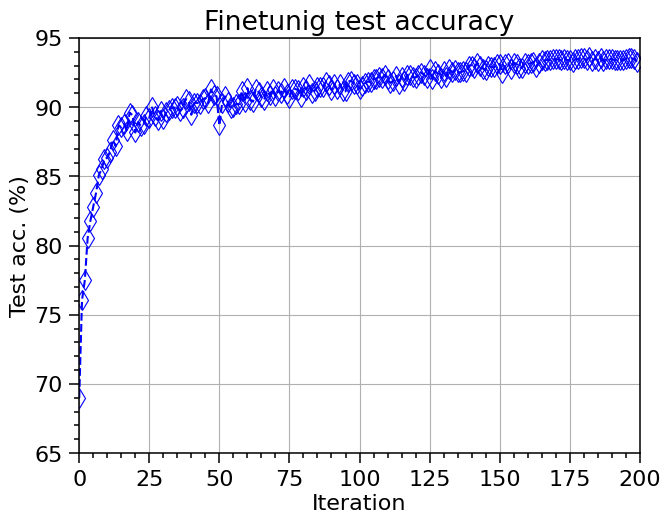

In [14]:
plt.title("Finetunig test accuracy")
plt.plot(test_accs, marker="d", linestyle="--", color="b")
plt.ylabel("Test acc. (%)")
plt.xlabel("Iteration")
plt.show()

We can also verify that the weights are clipped by looking at one random weight matrix in the network.

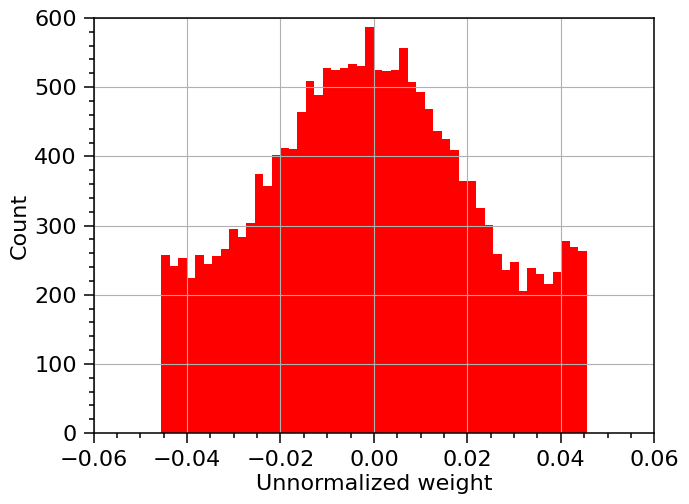

In [15]:
w, _ = (
    analog_model
    .layer3[0]
    .conv1.analog_module.get_weights(apply_weight_scaling=True)
)
plt.hist(w.flatten().detach().numpy(), color="r", bins=50)
plt.xlabel("Unnormalized weight")
plt.ylabel("Count")
plt.show()

Finally, we would like to see how robust our model is. We first have to convert our pre-trained model to analog.
We then repeatedly call `drift_analog_weights` with a time value (in seconds). This simulates the drifting of the weights to the specified time. Note that this call also programs the weights, i.e. it simulates programming by applying specific programming noise. This noise model is defined in the `noise_model` of the RPU config.

In [16]:
rpu_conf = gen_rpu_config()
converted_model = convert_to_analog(model, rpu_conf)
# - For programming the model, we need to put it into eval() mode
converted_model = converted_model.eval()
#analog_model = analog_model.eval()
# - We repeat each measurement 5 times
n_rep = 1
t_inferences = [60., 3600., 86400., 2592000., 31104000.]
drifted_test_accs_baseline = torch.zeros(size=(len(t_inferences),n_rep))
converted_model.program_analog_weights(noise_model = rpu_conf.noise_model)


In [19]:
model.layer1[0].conv1.weight[:,0,0,0]

tensor([-0.1376, -0.0720, -0.0465, -0.0819,  0.0241, -0.1537,  0.0271, -0.0298,
         0.0135, -0.0142, -0.1135,  0.0273, -0.0206, -0.0125, -0.0610,  0.0179],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [22]:
converted_model.get_weights()['layer1.0.conv1.analog_module'][0][:,0]

tensor([-0.1410, -0.0706, -0.0592, -0.0731,  0.0262, -0.1532,  0.0320, -0.0309,
         0.0129, -0.0056, -0.1123,  0.0440, -0.0249, -0.0134, -0.0654,  0.0238])

In [18]:
n_rep = 1
#t_inferences = [60., 3600., 86400., 2592000., 31104000.]
t_inferences = [1., 10., 60.]
drifted_test_accs = torch.zeros(size=(len(t_inferences),n_rep))
drifted_test_accs_baseline = torch.zeros(size=(len(t_inferences),n_rep))
prog = test_step(converted_model, criterion, testloader)
print(prog)
for i,t in enumerate(t_inferences):
    for j in range(n_rep):
        analog_model.drift_analog_weights(t)
        print(analog_model.get_weights()['layer1.0.conv1.analog_module'][0][:,0])
        print("Drifted at t: ", t)
        drifted_test_accs_baseline[i,j] = test_step(analog_model, criterion, testloader)
        print(drifted_test_accs_baseline[i,j])


Test loss 0.0286 test acc. 26.62%
26.62
tensor([-0.0563, -0.0267, -0.0055, -0.0490, -0.0270, -0.0694,  0.0068,  0.0094,
         0.0136, -0.0048, -0.0372, -0.0129,  0.0311, -0.0052, -0.0296, -0.0220])
Drifted at t:  1.0
Test loss 0.0019 test acc. 93.28%
tensor(93.2800)
tensor([-0.0553, -0.0261, -0.0057, -0.0466, -0.0284, -0.0681,  0.0041,  0.0076,
         0.0119, -0.0052, -0.0382, -0.0134,  0.0319, -0.0065, -0.0276, -0.0232])
Drifted at t:  10.0
Test loss 0.0022 test acc. 92.23%
tensor(92.2300)
tensor([-0.0571, -0.0267, -0.0075, -0.0477, -0.0290, -0.0679,  0.0056,  0.0075,
         0.0114, -0.0024, -0.0368, -0.0116,  0.0313, -0.0071, -0.0291, -0.0234])
Drifted at t:  60.0
Test loss 0.0032 test acc. 88.71%
tensor(88.7100)
